[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aldomunaretto/immune_deep_learning/blob/main/notebooks/04_NLP/21_NLP_sentiment_analysis_with_embeddings.ipynb)

<h1><font color="#113D68" size=6>Procesamiento del Lenguaje Natural</font></h1>

<h1><font color="#113D68" size=5>Análisis de Sentimiento con Embedding, CNN y Modelos Pre-Entrenados</font></h1>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [0. Contexto](#section0)
* [1. Conjunto de datos de reseñas de películas](#section1)
* [2. Preparación de datos](#section2)
    * [2.1. Dividir en conjuntos de train y test](#section21)
    * [2.2. Revisiones de carga y limpieza](#section22)
    * [2.3. Definir un vocabulario](#section23)
* [3. Entrenar CNN con capa Embedding](#section3)
* [4. Evaluar modelo](#section4)
* [5. Modelos Pre-Entrenados (HuggingFace)](#section5)

---
<a id="section0"></a>
# <font color="#004D7F" size=6> 0. Contexto</font>

En este cuaderno, trabajaremos el desarrollo de modelos de word embedding con redes neuronales convolucionales para clasificar documentos. Más a detalle, trabajaremos:
- Preparar datos de texto para su clasificación con métodos de aprendizaje profundo.
- Desarrollar un modelo de clasificación neuronal con incrustación de palabras y capas convolucionales.
- Evaluar el modelo de clasificación neuronal.

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section1"></a>
# <font color="#004D7F" size=6>1. Conjunto de datos de reseñas de películas</font>

En este tutorial, utilizaremos el conjunto de datos de revisión de películas que hemos venido trabajando. Recordemos:
- El archivo tiene un directorio llamado `txt_sentoken`.
- Tiene dos subdirectorios con el texto `neg` y `pos`.
- Las revisiones se almacenan una por archivo con una convención de nomenclatura `cv000` a `cv999`.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Puede descargar el conjunto de datos [Movie Review Polarity Dataset (review polarity.tar.gz, 3MB)](http://www.cs.cornell.edu/people/pabo/movie-review-data/)

In [1]:
# Descargar el conjunto de datos
!wget https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

# Crear la carpeta 'data' si no existe
!mkdir -p data

# Descomprimir el archivo 'data.tar.gz' en la carpeta 'data'
!tar -xzf review_polarity.tar.gz -C data

--2024-06-08 09:47:47--  https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.53
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz’

review_polarity.tar 100%[===================>]   2.98M  1.65MB/s    in 1.8s    

2024-06-08 09:47:50 (1.65 MB/s) - ‘review_polarity.tar.gz’ saved [3127238/3127238]



<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Puede ver el artículo original [_A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts_](https://arxiv.org/abs/cs/0409058)

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section2"></a>
# <font color="#004D7F" size=6>2. Preparación de datos</font>

La preparación del conjunto de datos de reseñas de películas se describió por primera vez en capítulos anteriores. Aquí veremos 3 cosas:
1. Separación en train y test.
2. Cargar y limpiar los datos para eliminar puntuación y números.
3. Definición de un vocabulario de palabras preferidas.

<a id="section21"></a>
# <font color="#004D7F" size=5>2.1. Dividir en conjuntos de train y test</font>

Utilizaremos las últimas 100 reseñas positivas y negativas como test (100 reseñas) y las 1800 restantes como train, i.e., tendremos una partición de 90%/10%.

<a id="section22"></a>
# <font color="#004D7F" size=5>2.2. Revisiones de carga y limpieza</font>

En esta fase de limpieza nos centraremos en:
- Dividir los Tokens por espacios en blanco.
- Eliminar toda la puntuación de las palabras.
- Eliminar todas las palabras que no estén compuestas únicamente por caracteres alfabéticos.
- Eliminar todas las palabras `stopwords`.
- Eliminar todas las palabras que tengan una longitud $\leq$ 1 carácter.

Desarrollamos:
- La función `clean_doc()` que carga un documento y devuelve una lista de tokens limpios.
- La función `load_doc()` que carga un documento desde un archivo listo para usar con la función `clean_doc()`.

In [2]:
import nltk
from nltk.corpus import stopwords
import string
import re

nltk.download('stopwords')

def load_doc(filename):
    with open(filename, 'r') as f:
      text = f.read()
    return text

def clean_doc(doc):
    tokens = doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('',w) for w in tokens] # eliminamos signos de puntuación
    tokens = [word for word in tokens if word.isalpha()] #eliminamos palabras que no sean alfanumericas
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words] #eliminamos stopwords
    tokens = [word for word in tokens if len(word)>1] # eliminamos todas las palabras que tengan menos de una letra
    return tokens

filename = 'data/txt_sentoken/pos/cv000_29590.txt'
text = load_doc(filename)
tokens = clean_doc(text)
print(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...


['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'theyre', 'superheroes', 'batman', 'superman', 'spawn', 'geared', 'toward', 'kids', 'casper', 'arthouse', 'crowd', 'ghost', 'world', 'theres', 'never', 'really', 'comic', 'book', 'like', 'hell', 'starters', 'created', 'alan', 'moore', 'eddie', 'campbell', 'brought', 'medium', 'whole', 'new', 'level', 'mid', 'series', 'called', 'watchmen', 'say', 'moore', 'campbell', 'thoroughly', 'researched', 'subject', 'jack', 'ripper', 'would', 'like', 'saying', 'michael', 'jackson', 'starting', 'look', 'little', 'odd', 'book', 'graphic', 'novel', 'pages', 'long', 'includes', 'nearly', 'consist', 'nothing', 'footnotes', 'words', 'dont', 'dismiss', 'film', 'source', 'get', 'past', 'whole', 'comic', 'book', 'thing', 'might', 'find', 'another', 'stumbling', 'block', 'hells', 'directors', 'albert', 'allen', 'hughes', 'getting', 'hughes', 'brothers', 'direct', 'seems', 'almost', 'ludicrous', 'casting', 'carrot', 'top', 'well', 'anythi

[nltk_data]   Unzipping corpora/stopwords.zip.


<a id="section23"></a>
# <font color="#004D7F" size=5>2.3. Definir un vocabulario</font>

En nuestro caso:
- Desarrollamos un vocabulario a modo de `Counter`:
    - Recordamos que es un diccionario de mapeo de palabras y su conteo que nos permite actualizar y consultar fácilmente.
- Cada documento se puede agregar al contador con la función `add_doc_to_vocab()`.
- Pasamos todas las revisiones en el directorio negativo y luego en el directorio positivo con la función `process_docs()`.

In [3]:
from os import listdir
from collections import Counter

def add_doc_to_vocab(filename, vocab):
  doc = load_doc(filename)
  tokens = clean_doc(doc)
  vocab.update(tokens)

def process_docs(directory, vocab):
  for filename in listdir(directory):
      if filename.startswith('cv9'):
          continue
      path = directory + '/' + filename
      add_doc_to_vocab(path,vocab)

vocab = Counter()
process_docs('data/txt_sentoken/pos', vocab)
process_docs('data/txt_sentoken/neg', vocab)

print(len(vocab))
print()
print(vocab.most_common(50))

44276

[('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('bad', 1248), ('could', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]


La salida muestra que:
- Tenemos un vocabulario de 44,276 palabras.
- Podemos ver una muestra de las 50 palabras más utilizadas.

Eliminamos las palabras que tengan menos de 2 ocurrencias.

In [4]:
tokens = [k for k,c in vocab.items() if c>=2]
print(len(tokens))

25767


Hemos reducido el tamaño de nuestro vocabulario a la mitad, de 44.276 a 25.767 palabras.

La función `save_list()` lo que hace es guardar el vocabulario creado para proyectos futuros.

In [5]:
def save_list(lines, filename):
    data = '\n'.join(lines)
    with open(filename, 'w') as f:
      f.write(data)

In [6]:
save_list(tokens, 'vocab.txt')

Vemos como es `vocab.txt`.

In [7]:
with open("vocab.txt") as f:
  archivo = f.read()
print(archivo)

life
beautiful
rare
treat
lighthearted
comedy
tackles
serious
subject
without
committing
sins
disrespectful
even
worse
humorless
combines
charming
romance
dash
farce
stirs
little
poignancy
ends
enjoyable
movie
italian
film
dont
let
discourage
missing
wonderful
experience
opens
sweet
romantic
good
natured
guido
roberto
benigni
arriving
rustic
town
work
waiter
uncle
year
literally
stumbles
girl
dreams
dora
nicoletta
braschi
seems
picture
perfect
one
stumbling
block
shes
already
engaged
another
man
overcome
odds
win
think
however
five
years
later
things
taken
turn
italy
fascists
stepped
race
initiatives
bad
news
jewish
new
son
giosue
giorgio
cantarini
rounded
shipped
concentration
camp
unable
protect
boy
way
attempts
shield
young
horrors
labor
pretends
everything
elaborate
game
points
awarded
tasks
hiding
brave
quiet
tell
description
two
different
tones
manages
excel
funny
bittersweet
tale
hope
amid
despair
touching
benignis
compared
best
chaplins
easy
see
able
run
gamut
comic
expression


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section3"></a>
# <font color="#004D7F" size=6>3. Entrenar CNN con capa `Embedding`</font>

La representación vectorial de valor real para las palabras se puede aprender mientras se entrena la red neuronal. Podemos hacer esto en la biblioteca de aprendizaje profundo de Keras usando la capa a`Embedding`.
- El primer paso es cargar el vocabulario.
- Lo usaremos para filtrar palabras de reseñas de películas que no nos interesen.
- Si ha trabajado en la sección anterior, debería tener un archivo local llamado `vocab.txt` con una palabra por línea.
- Podemos cargar ese archivo y construir un vocabulario como un conjunto para verificar la validez de lo tokens.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Word2Vec en [Wikipedia](https://en.wikipedia.org/wiki/Word2vec)

In [8]:
import string
import re
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D

In [9]:
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

Limpiamos el documento implica dividir cada revisión en función de los espacios en blanco, eliminar la puntuación y luego filtrar todos los tokens que no están en el vocabulario.

In [10]:
def clean_doc(doc, vocab):
  tokens = doc.split()
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  tokens = [re_punc.sub('',w) for w in tokens]
  tokens = [word for word in tokens if word in vocab]
  tokens = ' '.join(tokens)
  return tokens


Actualizamos `process_docs()` para que pueda llamar a la función `clean_doc()` para cada documento en un directorio determinado.

In [11]:
def process_docs(directory, vocab, is_train):
    documents = list()
    for filename in listdir(directory):
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        path = directory + '/' + filename
        doc = load_doc(path)
        tokens = clean_doc(doc, vocab)
        documents.append(tokens)
    return documents

Podemos llamar a la función `process_docs()` para los directorios `neg` y `pos` y combinar las revisiones en un solo train o test. También podemos definir las etiquetas de clase para el conjunto de datos.

La función `load_clean_dataset()` a continuación cargará todas las revisiones y preparará etiquetas de clase para el conjunto de datos de train/test.

In [12]:
def load_clean_dataset(vocab, is_train):
    neg = process_docs('data/txt_sentoken/neg', vocab, is_train)
    pos = process_docs('data/txt_sentoken/pos', vocab, is_train)
    docs = neg + pos
    labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))])
    return docs, labels

El siguiente paso es codificar cada documento como una secuencia de números enteros.
- La capa `Embedding` de Keras requiere entradas de enteros donde cada entero se asigna a un solo token que tiene una representación vectorial de valor real específica dentro de la incrustación.
- Estos vectores son aleatorios al comienzo del entrenamiento, pero durante el entrenamiento se vuelven significativos para la red.
- Podemos codificar los documentos de entrenamiento como secuencias de números enteros utilizando la clase `Tokenizer` en la API de Keras.
    - Primero, debemos construir una instancia de la clase y luego entrenarla en todos los documentos del conjunto de datos de entrenamiento.
    - En este caso, desarrolla un vocabulario de todos los tokens en el conjunto de datos de entrenamiento y desarrolla un mapeo consistente de palabras en el vocabulario a enteros únicos.
    - La función `create_tokenizer()` a continuación preparará un `Tokenizer` a partir de los datos de entrenamiento.

In [13]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

- Ahora que se ha preparado la asignación de palabras a números enteros, podemos usarla para codificar las reseñas en el conjunto de datos de entrenamiento.
- Podemos hacer eso llamando a la función `texts_to_sequences()` en el `Tokenizer`.
- También debemos asegurarnos de que todos los documentos tengan la misma longitu
- En este caso, rellenaremos todas las revisiones con la duración más larga en train.
    - Primero, buscamos la revisión más larga con la función `max()`.
    - A continuación, llamamos la función `pad_Sequences()` para rellenar las secuencias hasta la longitud máxima añadiendo 0 valores al final.

In [14]:
train_docs, ytrain = load_clean_dataset(vocab, True)
# Calcular la secuencia máxima
max_length = max([len(s.split()) for s in train_docs])
print('Maximum length: %d' % max_length)

Maximum length: 1317


Luego podemos usar la longitud máxima como un parámetro para una función para codificar enteros y rellenar las secuencias.

In [15]:
def encode_docs(tokenizer, max_length, docs):
    # Codificar a entero
    encoded = tokenizer.texts_to_sequences(docs)
    # rellenar secuencias
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

Ahora estamos listos para definir nuestro modelo de red neuronal.
1. El modelo utilizará una capa `Embedding` como la primera capa oculta.
2. La capa `Embedding` requiere la especificación del tamaño del vocabulario, el tamaño del espacio vectorial de valor real y la longitud máxima de los documentos de entrada.
3. El tamaño del vocabulario es el número total de palabras en nuestro vocabulario, más una para las palabras desconocidas.

In [16]:
# Cargar datos de entrenamiento
train_docs, ytrain = load_clean_dataset(vocab, True)
# Crear el Tokenizer
tokenizer = create_tokenizer(train_docs)
# Definir el tamaño de vocabulario
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)

Vocabulary size: 25768


1. Usaremos un espacio vectorial de 100 dimensiones, pero puede probar otros valores, como 50 o 150.
2. La longitud máxima del documento se calculó anteriormente.
3. Definirmos nuestro modelo, incluida la capa `Embedding`.
4. Se utiliza una configuración CNN conservadora con 32 filtros (campos paralelos para procesar palabras), un tamaño de kernel de 8 y ReLU.
5. Definimos capa de MaxPooling.
6. Aplanamos en un vector las características extraídas por CNN.
7. Definimos una capa Densa con ReLU.
8. La capa de salida utiliza Sigmoide para generar un valor entre 0 (negativo) y 1 (positivo).


En el procesamiento del lenguaje natural (NLP), las redes neuronales convolucionales de una dimensión (1D) se utilizan principalmente debido a su capacidad para capturar patrones locales en las secuencias de texto. Aquí hay algunas razones clave por las cuales las convolucionales de 1D son útiles en NLP:

**Captura de Dependencias Locales:** Las convoluciones 1D son excelentes para capturar relaciones locales en secuencias de texto, como frases y combinaciones de palabras, lo cual es crucial para entender el significado en el lenguaje natural.

**Reducción de Dimensionalidad:** Las convoluciones pueden reducir la dimensionalidad de las representaciones de texto al tiempo que preservan información importante, lo que facilita el manejo de secuencias largas sin perder características esenciales.

**Eficiencia Computacional:** Comparadas con otros modelos como las LSTM (Long Short-Term Memory) o las Transformer, las convoluciones 1D son computacionalmente menos costosas y pueden ser más rápidas en el entrenamiento y la inferencia.

**Extracción de Características:** Las capas convolucionales son buenas para extraer características jerárquicas, empezando por las más simples (como caracteres o palabras individuales) y construyendo gradualmente características más complejas (como frases o conceptos).

**Flexibilidad:** Las convoluciones 1D pueden aplicarse a diferentes niveles de representaciones textuales, desde caracteres hasta palabras y frases, lo que las hace muy versátiles para diversas tareas en NLP.

**Combinación con Otras Técnicas:** Pueden combinarse fácilmente con otros tipos de redes neuronales, como LSTM o Transformer, para mejorar el rendimiento en tareas específicas. Por ejemplo, se pueden usar convoluciones para una extracción inicial de características seguida de capas recurrentes para modelar dependencias a largo plazo.

In [17]:
def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Conv1D(32, 8, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

Podemos ver que la capa `Embedding` espera documentos con una longitud de 1317 palabras como entrada y codifica cada palabra del documento como un vector de 100 elementos y el tamaño del vocabulario de 25768.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1317, 100)         2576800   
                                                                 
 conv1d (Conv1D)             (None, 1310, 32)          25632     
                                                                 
 max_pooling1d (MaxPooling1  (None, 655, 32)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 20960)             0         
                                                                 
 dense (Dense)               (None, 10)                209610    
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                        

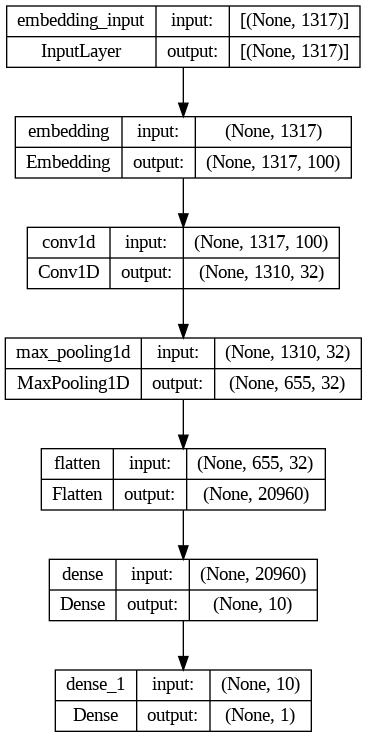

In [18]:
model = define_model(vocab_size, max_length)

# compilacion
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

plot_model(model, to_file='model.png', show_shapes=True)

A continuación, se guarda un gráfico del modelo definido en un archivo con el nombre `model.png`.
  <img src="img/model_52.png" width="200" height="200" alt="CNN NLP">
  
A continuación, ajustamos la red a los datos de entrenamiento.
1. Usamos una función de pérdida de entropía cruzada binaria porque el problema que estamos aprendiendo es un problema de clasificación binaria.
2. Se utiliza la implementación eficiente de Adam del descenso de gradiente estocástico y realizamos un seguimiento del accuracy además de la pérdida durante el entrenamiento.
3. El modelo se entrena para 10 épocas, o 10 pases a través de los datos de entrenamiento.
4. La configuración de la red y el programa de capacitación se encontraron con un poco de prueba y error, pero de ninguna manera son óptimos para este problema.


In [19]:
# Codificamos los datos
Xtrain = encode_docs(tokenizer, max_length, train_docs)

# Hacemos el fit
model.fit(Xtrain, ytrain, epochs=10, verbose=1)

Epoch 1/10
57/57 [==============================] - 16s 197ms/step - loss: 0.6877 - accuracy: 0.5356
Epoch 2/10
57/57 [==============================] - 8s 140ms/step - loss: 0.4495 - accuracy: 0.8244
Epoch 3/10
57/57 [==============================] - 8s 150ms/step - loss: 0.0325 - accuracy: 0.9961
Epoch 4/10
57/57 [==============================] - 9s 153ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 5/10
57/57 [==============================] - 8s 141ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 6/10
57/57 [==============================] - 7s 126ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 7/10
57/57 [==============================] - 6s 103ms/step - loss: 8.6825e-04 - accuracy: 1.0000
Epoch 8/10
57/57 [==============================] - 8s 138ms/step - loss: 6.7080e-04 - accuracy: 1.0000
Epoch 9/10
57/57 [==============================] - 6s 96ms/step - loss: 5.3483e-04 - accuracy: 1.0000
Epoch 10/10
57/57 [==============================] - 7s 125ms/step - loss: 4.3281e-04 - 

Una vez ajustado el modelo, se guarda en un archivo denominado `model.h5` para su posterior evaluación.

In [20]:
# Guardamos el modelo
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Ejecutar el ejemplo primero proporcionará un resumen del vocabulario del conjunto de datos de entrenamiento (25,768) y la longitud máxima de la secuencia de entrada en palabras (1,317). El ejemplo debería ejecutarse en unos minutos y el modelo de ajuste se guardará en un archivo.

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section4"></a>
# <font color="#004D7F" size=6>4. Evaluar modelo</font>

En esta sección, evaluaremos el modelo entrenado y lo usaremos para hacer predicciones sobre nuevos datos.

Podemos usar la función integrada `evaluate()` para estimar la habilidad del modelo en el conjunto de datos de train y test. Esto requiere que carguemos y codifiquemos los conjuntos de datos de train y test.

In [21]:
# train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)

# Xtrain = encode_docs(tokenizer, max_length, train_docs)
Xtest = encode_docs(tokenizer, max_length, test_docs)

Luego podemos cargar el modelo y evaluarlo en ambos conjuntos de datos e imprimir el accuracy.

In [22]:
# Cargamos el modelo entrenado
model = load_model('model.h5')
# Evaluamos en train
_, acc = model.evaluate(Xtrain, ytrain, verbose=1)
print('Accuracy en Train: %.2f' % (acc*100))
# Evaluamos en Test
_, acc = model.evaluate(Xtest, ytest, verbose=1)
print('Accuracy en Test: %.2f' % (acc*100))

57/57 [==============================] - 0s 4ms/step - loss: 3.7263e-04 - accuracy: 1.0000
Accuracy en Train: 100.00
7/7 [==============================] - 0s 5ms/step - loss: 0.4369 - accuracy: 0.8500
Accuracy en Test: 85.00


Luego podemos cargar el modelo y evaluarlo en ambos conjuntos de datos e imprimir el accuracy.

In [23]:
def predict_sentiment(review, vocab, tokenizer, max_length, model):
    line = clean_doc(review, vocab)
    # Codificar y rellenar
    padded = encode_docs(tokenizer, max_length, [line])
    # Predecir la reseña
    yhat = model.predict(padded, verbose=1)
    # Extraer el porcentaje de la reseña dado
    porc_pos = yhat[0,0]
    if round(porc_pos)==0:
      return (1 - porc_pos), 'NEGATIVO'
    return porc_pos, 'POSITIVO'

Podemos probar este modelo con dos reseñas de películas ad hoc.

In [24]:
text = 'Best movie ever! It was great, I recommend it.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))


1/1 [==============================] - 0s 189ms/step
Review: [Best movie ever! It was great, I recommend it.]
Sentiment: POSITIVO (51.516%)
1/1 [==============================] - 0s 18ms/step
Review: [This is a bad movie.]
Sentiment: NEGATIVO (51.908%)


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section5"></a>
# <font color="#004D7F" size=6>5. Modelos Pre-Entrenados (HuggingFace)</font>

En esta sección, utilizaremos modelos pre-entrenados proporcionados por la librería HuggingFace, específicamente modelos de Transformers, para realizar análisis de sentimiento. HuggingFace ofrece una amplia gama de modelos pre-entrenados que se pueden adaptar y utilizar para diversas tareas de procesamiento de lenguaje natural (NLP).

He aqui algunas referencias:
1. https://huggingface.co/blog/sentiment-analysis-python  
2. https://www.kdnuggets.com/how-to-fine-tune-bert-sentiment-analysis-hugging-face-transformers  
3. https://brighteshun.medium.com/sentiment-analysis-part-1-finetuning-and-hosting-a-text-classification-model-on-huggingface-9d6da6fd856b  

In [25]:
import torch
torch.cuda.is_available()

True

In [26]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you", "Best movie ever! It was great, I recommend it.", "This is a bad movie.", "This coffie was like I was diving on lava", "I felt asleep three time during our conversation"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that aut

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079},
 {'label': 'POSITIVE', 'score': 0.9998816251754761},
 {'label': 'NEGATIVE', 'score': 0.9997982382774353},
 {'label': 'NEGATIVE', 'score': 0.9575932621955872},
 {'label': 'NEGATIVE', 'score': 0.9989781379699707}]

In [27]:
specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
specific_model(data)

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'POS', 'score': 0.9916695356369019},
 {'label': 'NEG', 'score': 0.9806600213050842},
 {'label': 'POS', 'score': 0.9922116994857788},
 {'label': 'NEG', 'score': 0.9817050695419312},
 {'label': 'NEU', 'score': 0.6966434717178345},
 {'label': 'NEU', 'score': 0.8242086172103882}]

In [28]:
specific_model = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment-latest")
specific_model(data)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

[{'label': 'positive', 'score': 0.8594691753387451},
 {'label': 'negative', 'score': 0.7866929769515991},
 {'label': 'positive', 'score': 0.9879410862922668},
 {'label': 'negative', 'score': 0.9310840964317322},
 {'label': 'negative', 'score': 0.5595480799674988},
 {'label': 'neutral', 'score': 0.7745545506477356}]

In [10]:
#!pip install datasets
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

5.2 **Carga del Modelo y Tokenizador:** Para este ejemplo, utilizaremos el modelo distilbert-base-uncased de HuggingFace. Este modelo es una versión más ligera de BERT, diseñado para ser más rápido y eficiente en términos de recursos computacionales.

In [1]:
from datasets import load_dataset
imdb = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

5.3 **Preparación de los Datos:** A continuación, preparamos los datos para que sean compatibles con el modelo. Esto implica tokenizar los textos y convertirlos en tensores que el modelo pueda procesar.

In [4]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [5]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [6]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

5.4 **Entrenamiento y Evaluación del Modelo:** Para entrenar y evaluar el modelo, utilizamos el Trainer de HuggingFace, que facilita el proceso de entrenamiento y evaluación de modelos de Transformers.

In [8]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model-3000-samples"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=False,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [9]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=376, training_loss=0.3113025097136802, metrics={'train_runtime': 296.1228, 'train_samples_per_second': 20.262, 'train_steps_per_second': 1.27, 'total_flos': 782725021021056.0, 'train_loss': 0.3113025097136802, 'epoch': 2.0})

5.5 **Evaluación del Modelo:** Finalmente, evaluamos el modelo utilizando los datos de prueba para obtener métricas de rendimiento como la precisión y la F1.

In [10]:
trainer.evaluate()

<ipython-input-7-2457e8bb4065>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.29114389419555664,
 'eval_accuracy': 0.8866666666666667,
 'eval_f1': 0.8903225806451613,
 'eval_runtime': 6.3254,
 'eval_samples_per_second': 47.428,
 'eval_steps_per_second': 3.004,
 'epoch': 2.0}

5.6 **Conclusiones:** El uso de modelos pre-entrenados de HuggingFace nos permite aprovechar el poder de los Transformers para tareas de NLP de manera eficiente y efectiva. En este ejemplo, hemos demostrado cómo cargar, entrenar y evaluar un modelo pre-entrenado para análisis de sentimiento, obteniendo resultados precisos en un conjunto de datos estándar.